<p style="display:flex; align-items:center;">
  <img src="https://upload.wikimedia.org/wikipedia/it/1/11/Napoli_university_seal_alfachannel.png"
       alt="Logo UNINA" width="10%" style="margin-right:2%;">
  <img src="https://indico.unina.it/event/58/attachments/172/352/logo_dieti.png"
       alt="Logo DIETI" width="10%">
</p>


# Unupervised (Guided) Anomaly Detection using Machine Learning, Deep Learning, and Generative AI

---

***Practical Network Intrusion Detection with Machine Learning and Generative AI***

Prof. Giampaolo Bovenzi


In [24]:
# Colab bootstrap
import os, sys, subprocess, importlib, pathlib

REPO_URL = "https://github.com/jmpr0/practical-nids"
REPO_DIR = "/content/practical-nids"

if not pathlib.Path(REPO_DIR).exists():
    subprocess.run(["git", "clone", REPO_URL, REPO_DIR], check=True)

os.chdir(REPO_DIR)

# Install deps
subprocess.run([sys.executable, "-m", "pip", "install", "-r", "/content/practical-nids/requirements.txt", "--quiet"], check=True)

# Create outputs dirs
for d in ["outputs", "data/cache", "models"]:
    pathlib.Path(d).mkdir(parents=True, exist_ok=True)

print("Setup OK in", os.getcwd())


Setup OK in /content/practical-nids


# Loading Utility Modules
This module handles loading and preprocessing of datasets for anomaly detection, provides visualization functions to assess model performance, and manages logging of results and outputs to disk.

In [25]:
from utils.data import load_data, preprocess_data
from utils.plot import plot_roc, plot_score_hist_with_thresholds
from utils.logging import DiskLogger

from time import time
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from utils.training import TimeEpochs
from livelossplot.tf_keras import PlotLossesCallback

# Data Preparation

Set seed for reproducibiity

In [26]:
from utils.reproducibility import set_seed
set_seed(42)

Setup the configuration parameters for data results and handling

In [27]:
import os

validation_split = 0.1    # Fraction of training data used for validation
results_path = './results'  # Base directory to save results
dataset_name = 'kdd'      # Name of the dataset (i.e., 'kdd' and 'iot-23)
noise_std = 0.0           # Noise standard deviation for training robustness


Dataset loading and preprocessing

In [28]:
import numpy as np

# Load the dataset and preprocess it
print("Loading data...")
X_train, y_train, X_test, y_test, X_val, y_val = load_data(
    dataset_name=dataset_name, validation_split=validation_split)

print("Processing data...")
X_train, y_train, X_test, y_test, X_val, y_val, encoded_legit_class = preprocess_data(
    X_train, y_train, X_test, y_test, X_val, y_val,
    dataset_name=dataset_name
)

# Filter out only the "normal" data points for training
# This ensures the model learns from legitimate (non-anomalous) data
X_train = X_train[np.where(y_train == encoded_legit_class)]
if X_val is not None:
  X_val = X_val[np.where(y_val == encoded_legit_class)]

# Introduce noise to the training data (if applicable)
# This helps with robustness and generalization in anomaly detection
X_train_noise = np.random.normal(0, noise_std, X_train.shape)


Loading data...
Processing data...


Dataset distribution visualization

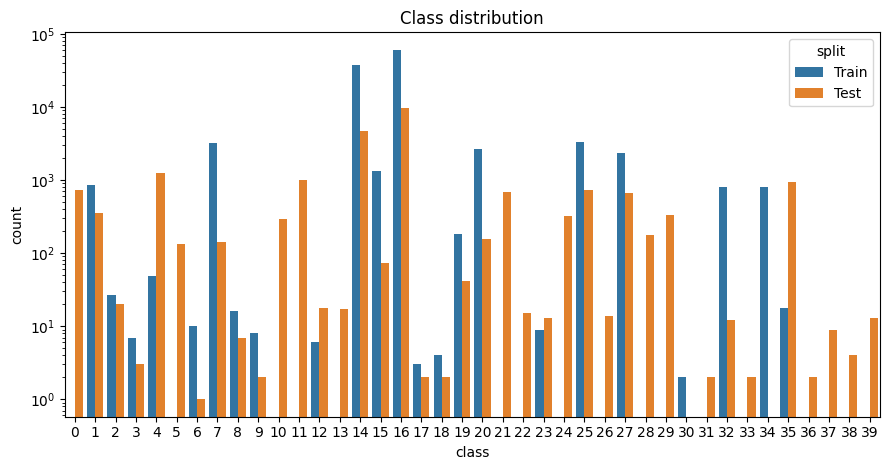

Percentage of legitimate traffic: 53.46 %
Percentage of non-legitimate traffic: 46.54 %


In [29]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

ct, nt = np.unique(y_train, return_counts=True); cv, nv = np.unique(y_test, return_counts=True)
fig, ax = plt.subplots(figsize=(9,4.8))
df = (pd.DataFrame({'class':np.r_[ct,cv],'count':np.r_[nt,nv],'split':['Train']*len(ct)+['Test']*len(cv)})
        .pivot_table(index='class', columns='split', values='count', fill_value=0)
        .stack().rename('count').reset_index())
sns.barplot(data=df, x='class', y='count', hue='split', hue_order=['Train', 'Test'], ax=ax)
ax.set_title('Class distribution')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

print('Percentage of legitimate traffic: %.2f' % (sum([t == encoded_legit_class for t in y_train]) / len(y_train) * 100), '%')
print('Percentage of non-legitimate traffic: %.2f' % (sum([t != encoded_legit_class for t in y_train]) / len(y_train) * 100), '%')

# Anomaly Detection via Machine Learning

## Isolation Forest with pyOD

In [30]:
import os
import numpy as np
from pyod.models.iforest import IForest
from sklearn.metrics import roc_auc_score

# Initialize and train the IF model
if_ = IForest(n_estimators=100, max_samples='auto', contamination=0.01)
if_.fit(X_train)


IForest(behaviour='old', bootstrap=False, contamination=0.01,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

ROC AUC Score: 0.9422
ROC Partial AUC Score: 0.7198


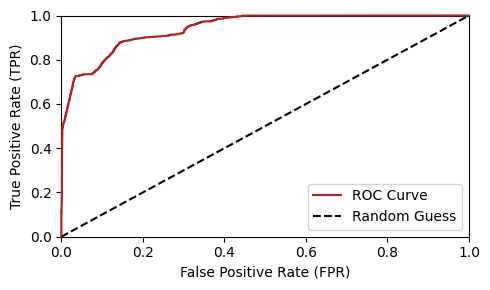

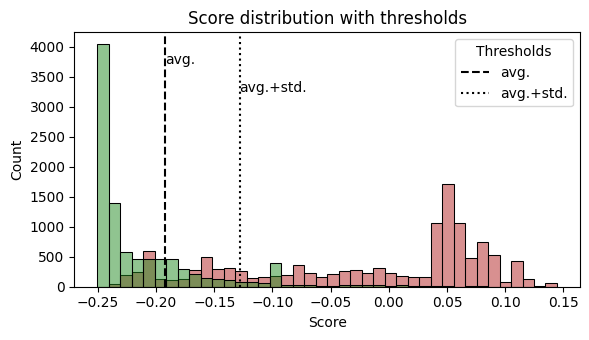

TPR-FPR @avg: 0.91-0.24
TPR-FPR @avg+std: 0.77-0.10


In [31]:
# Extract IF raw scores (higher score = more anomalous)
y_score = if_.decision_function(X_test)  # Raw anomaly scores
y_score_val = if_.decision_function(X_val)  # Raw anomaly scores

# Convert y_test to binary format if necessary (ensure it's 0 or 1)
y_test_binary = [0 if v == encoded_legit_class else 1 for v in y_test.astype(int)]

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test_binary, y_score)
print(f'ROC AUC Score: {roc_auc:.4f}')
roc_pauc = roc_auc_score(y_test_binary, y_score, max_fpr=0.01)
print(f'ROC Partial AUC Score: {roc_pauc:.4f}')

# Define the save path (modify `results_path` and `model_name` accordingly)
results_path = "./results"  # Change this to your preferred directory
model_name = "IF"
os.makedirs(results_path, exist_ok=True)

# Plot and save the ROC curve
plot_roc(
    y_test_binary,
    y_score,
    savefig=os.path.join(results_path, f'ROC_{model_name}')
)

metrics = plot_score_hist_with_thresholds(
    y_true=y_test_binary,
    y_score=y_score,
    y_score_val=y_score_val,          # or None to use y_score
    figsize=(6, 3.5),
    bins=40,
    stat="count",
    title="Score distribution with thresholds",
)
print(f"TPR-FPR @avg: {metrics['tpr_thr_avg']:.2f}-{metrics['fpr_thr_avg']:.2f}")
print(f"TPR-FPR @avg+std: {metrics['tpr_thr_avg_std']:.2f}-{metrics['fpr_thr_avg_std']:.2f}")

# Anomaly Detection via Deep Learning

## Autoencoder-based Detectors with Keras

Importing a simple autoencoder, a deep autoencoder (for better feature extraction), and the KitNET (ensemble of shallow autoencoders) used for anomaly detection.

In [32]:
from model.autoencoder import AE
from model.deepautoencoder import DAE
from model.kitnet import KitNET

Setup the configuration parameters for Autoencoder-based detectors and for results persistency

In [33]:
import os
from utils.data import log

# Set training parameters (previously argparse arguments)
model_name = 'autoencoder'     # Model choice
model_class = AE               # Model class
batch_size = 128          # Batch size for training
epochs = 50               # Number of training epochs
patience = 5              # Early stopping patience (number of epochs without improvement)

# Generate a timestamped results directory for experiment tracking
timestamp = f"{model_name}_{int(time())}"
exp_results_path = os.path.join(results_path, timestamp)

# Log experiment hyperparameters and configurations
experiment_config = {
    'model_name': model_name,           # Name of the selected model
    'noise_std': noise_std,             # Standard deviation of noise added to training data
    'batch_size': batch_size,           # Batch size for training
    'epochs': epochs,                   # Total number of training epochs
    'validation_split': validation_split,  # Fraction of training data used for validation
    'patience': patience,               # Patience for early stopping
    'results_path': exp_results_path        # Path where logs and results will be saved
}

log(exp_results_path, experiment_config)


Building and visualizing the detector model

Building model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 41)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 21)             │           882 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 41)             │           902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,784 (6.97 KB)

 Trainable params: 1,784 (6.97 KB)

 Non-trainable params: 0 (0.00 B)

None


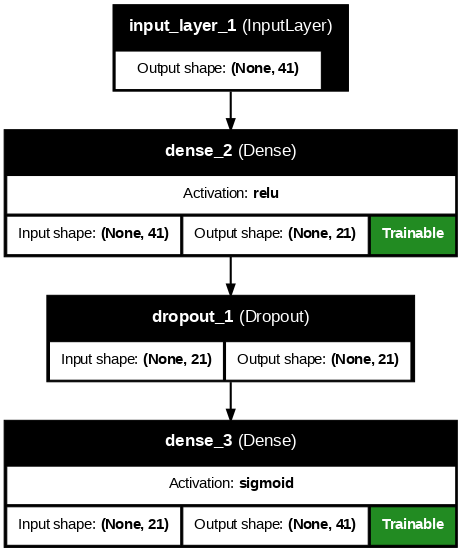

In [34]:
from tensorflow.keras.utils import plot_model

# Initialize and build the anomaly detection model
print("Building model...")

# Dynamically create the model instance using the specified model name
detector = model_class(X_train.shape[1])

# Compile the model with specified optimizer and loss function
# - `optimizer='sgd'`: Uses Stochastic Gradient Descent (SGD) for training
# - `loss='mse'`: Mean Squared Error (MSE) is commonly used in autoencoders
detector.compile(optimizer='sgd', loss='mse')

# Print the model summary to check its architecture
print(detector.print_summary())

plot_model(detector.model, show_shapes=True, show_layer_names=True, show_trainable=True, show_layer_activations=True, dpi=75)

Training the detector model

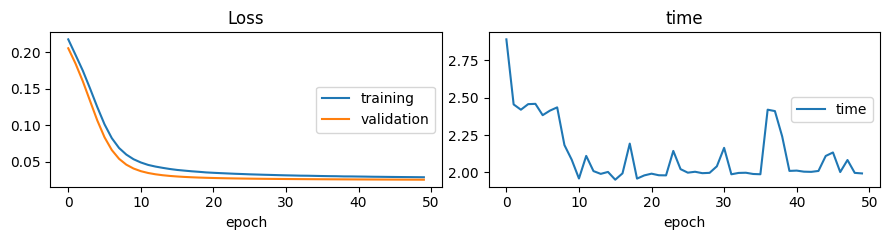

Loss
	training         	 (min:    0.029, max:    0.217, cur:    0.029)
	validation       	 (min:    0.025, max:    0.205, cur:    0.025)
time
	time             	 (min:    1.951, max:    2.889, cur:    1.993)
474/474 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0288 - val_loss: 0.0252 - time: 1.9934
Fit completed in 119.081 s.


In [35]:
from time import process_time

# Initialize a list to store callbacks
callbacks = []

# If validation split is used, warn the user and enable EarlyStopping
if validation_split > 0:
  print("WARNING: validation_split is used as validation.")
  # EarlyStopping: Stops training if `val_loss` does not improve for `patience` epochs
  callbacks.append(EarlyStopping(monitor='val_loss', patience=patience))

# Add additional callbacks for logging and tracking training time
callbacks.extend([
  TimeEpochs(),  # Tracks per-epoch execution time
  CSVLogger(f"{results_path}/log.csv", append=True),  # Logs training progress to a CSV file
  PlotLossesCallback(mode='notebook', figsize=(9, 2.5)),
])

# Start model training
print("Fitting model...")
start_time = process_time()  # Record start time for measuring training duration

# Train the model with the given dataset and specified hyperparameters
detector.fit(
  X_train + X_train_noise,  # Injecting noise into training data for robustness
  X_train,  # Target output is the original training data (autoencoder setup)
  batch_size=batch_size,
  epochs=epochs,
  validation_data=(X_val, X_val),  # Uses a fraction of training data for validation
  callbacks=callbacks,  # Passes callback functions for early stopping and logging
  verbose=1  # Displays training progress
)

# Display total training time
print(f"Fit completed in {process_time() - start_time:.3f} s.")


Inference on train, test, and validation sets; Saving results on disk

In [36]:
# Start model inference on the test dataset
print("Test inferring...")

# Record the start time to measure inference duration
start_time = process_time()

# Compute anomaly scores for the test set
# - `detector.score(X_test)`: Uses the trained model to predict anomaly scores
# - `verbose=1`: Prints progress if enabled
y_score = detector.score(X_test, verbose=1)

# Display total inference time and number of test instances processed
print(f"Inference of {len(y_score)} instances completed in {process_time() - start_time:.3f} s.")

# Save test inference results
print("Saving results...")

# Create a DataFrame to store true labels and predicted anomaly scores
df_output = pd.DataFrame({
    'y_true': y_test.astype(int),  # Convert true labels to integers
    'y_score': y_score             # Store anomaly scores
})

# Save the results as a Parquet file for efficient storage
df_output.to_parquet(os.path.join(results_path, 'targets_scores.parquet'))

# Perform inference on the training data
print("Train inferring...")
y_score_train = detector.score(X_train, verbose=1)

# Create a DataFrame for training scores
df_output_train = pd.DataFrame({'y_score': y_score_train})

# Save the training scores to a Parquet file
df_output_train.to_parquet(os.path.join(results_path, 'train_scores.parquet'))

if X_val is not None:
  # Perform inference on the training data
  print("Validation inferring...")
  y_score_val = detector.score(X_val, verbose=1)

  # Create a DataFrame for training scores
  df_output_val = pd.DataFrame({'y_score': y_score_val})

  # Save the training scores to a Parquet file
  df_output_val.to_parquet(os.path.join(results_path, 'val_scores.parquet'))


Test inferring...
705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Inference of 22544 instances completed in 1.504 s.
Saving results...
Train inferring...
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Validation inferring...
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Visualize results through AUC metrics, ROC Curve, and scoring function distributions

Plotting ROC curve...
ROC AUC Score: 0.9057
ROC Partial AUC Score: 0.7033


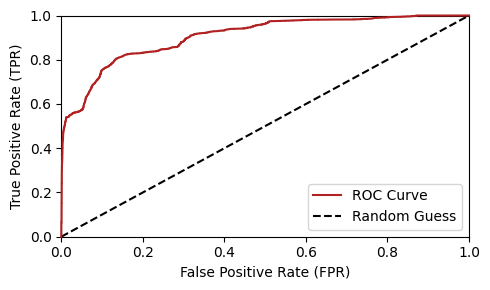

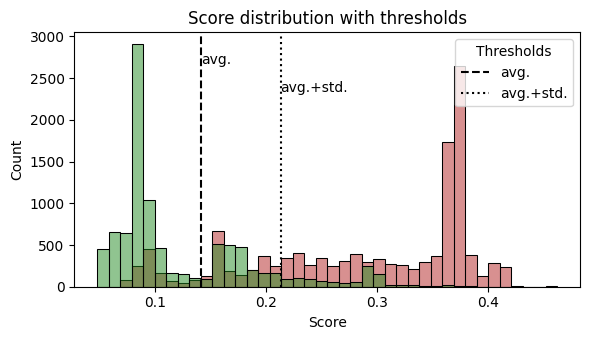

TPR-FPR @avg: 0.91-0.32
TPR-FPR @avg+std: 0.76-0.11


In [37]:
from sklearn.metrics import roc_auc_score

# Generate and save the ROC curve
print("Plotting ROC curve...")

# Convert `y_test` into binary format:
# - Assign `0` for the legitimate class (`encoded_legit_class`).
# - Assign `1` for anomalies (all other classes).
y_test_binary = [0 if v == encoded_legit_class else 1 for v in y_test.astype(int)]

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test_binary, y_score)
print(f'ROC AUC Score: {roc_auc:.4f}')
roc_pauc = roc_auc_score(y_test_binary, y_score, max_fpr=0.01)
print(f'ROC Partial AUC Score: {roc_pauc:.4f}')

# Plot the ROC curve and save it as a figure
plot_roc(
    y_test_binary,  # Ground truth binary labels
    y_score,        # Predicted anomaly scores
    savefig=os.path.join(results_path, f'ROC_{model_name}')  # Save as file
)

metrics = plot_score_hist_with_thresholds(
    y_true=y_test_binary,
    y_score=y_score,
    y_score_val=y_score_val,          # or None to use y_score
    figsize=(6, 3.5),
    bins=40,
    stat="count",
    title="Score distribution with thresholds",
)
print(f"TPR-FPR @avg: {metrics['tpr_thr_avg']:.2f}-{metrics['fpr_thr_avg']:.2f}")
print(f"TPR-FPR @avg+std: {metrics['tpr_thr_avg_std']:.2f}-{metrics['fpr_thr_avg_std']:.2f}")


# Anomaly Detection via Generative AI

## Variational AutoEncoder with pyOD

In [38]:
import os
import numpy as np
from pyod.models.vae import VAE
from sklearn.metrics import roc_auc_score
import math

# Initialize and train the VAE model
vae = VAE(contamination=0.01, preprocessing=True, lr=0.01, epoch_num=10,
                  batch_size=128, optimizer_name='sgd', device=None, random_state=42,
                  use_compile=False, compile_mode='default', verbose=1,
                  optimizer_params={},
                  encoder_neuron_list=[
                      math.ceil(X_train.shape[1] * .75),
                      math.ceil(X_train.shape[1] * .5)],
                  decoder_neuron_list=[
                      math.ceil(X_train.shape[1] * .5),
                      math.ceil(X_train.shape[1] * .75)],
                  hidden_activation_name='relu')

vae.fit(X_train)


Training: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


ROC AUC Score: 0.9191
ROC Partial AUC Score: 0.5254


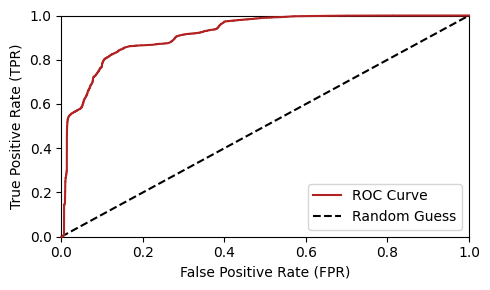

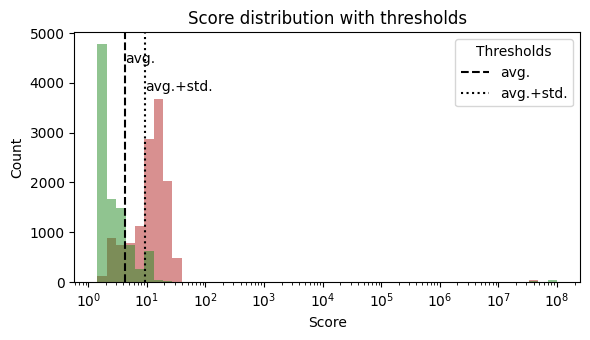

TPR-FPR @avg: 0.86-0.19
TPR-FPR @avg+std: 0.69-0.07


In [39]:
# Extract VAE raw scores (higher score = more anomalous)
y_score = vae.decision_function(X_test)  # Raw anomaly scores
y_score_val = vae.decision_function(X_val)  # Raw anomaly scores

# Convert y_test to binary format if necessary (ensure it's 0 or 1)
y_test_binary = [0 if v == encoded_legit_class else 1 for v in y_test.astype(int)]

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test_binary, y_score)
print(f'ROC AUC Score: {roc_auc:.4f}')
roc_pauc = roc_auc_score(y_test_binary, y_score, max_fpr=0.01)
print(f'ROC Partial AUC Score: {roc_pauc:.4f}')

# Define the save path (modify `results_path` and `model_name` accordingly)
results_path = "./results"  # Change this to your preferred directory
model_name = "VAE"
os.makedirs(results_path, exist_ok=True)

# Plot and save the ROC curve
plot_roc(
    y_test_binary,
    y_score,
    savefig=os.path.join(results_path, f'ROC_{model_name}')
)

metrics = plot_score_hist_with_thresholds(
    y_true=y_test_binary,
    y_score=y_score,
    y_score_val=y_score_val,          # or None to use y_score
    figsize=(6, 3.5),
    bins=None,
    stat="count",
    title="Score distribution with thresholds",
    xscale='log'
)
print(f"TPR-FPR @avg: {metrics['tpr_thr_avg']:.2f}-{metrics['fpr_thr_avg']:.2f}")
print(f"TPR-FPR @avg+std: {metrics['tpr_thr_avg_std']:.2f}-{metrics['fpr_thr_avg_std']:.2f}")

## GPT-2 with Huggingface

In [40]:
from utils.data import SimpleTokenizer, tabular_to_text, build_vocab
from utils.training import count_trainable_parameters
from transformers import GPT2Config
from model.gpt2 import GPT2Detector

In [41]:
X_train_text = tabular_to_text(X_train)
token2id, vocab_size = build_vocab(X_train_text)
print(f"Custom vocabulary size: {vocab_size}")

Custom vocabulary size: 2087


In [42]:
tokenizer = SimpleTokenizer(token2id)

config = GPT2Config(
    n_embd=32,
    n_layer=2,
    n_head=2,
    vocab_size=len(tokenizer.token2id),
    pad_token_id=tokenizer.pad_token_id
)

# Model instantiation
gpt2_detector = GPT2Detector(config, tokenizer)

In [43]:
num_params = count_trainable_parameters(gpt2_detector.model)
print(f"Trainable parameters: {num_params}")

# Prepare test and validation data from numeric array
X_test_text = tabular_to_text(X_test)
X_val_text = tabular_to_text(X_val)

# Train for 10 epochs
gpt2_detector.fit(X_train_text, X_val=X_val_text, epochs=10, batch_size=8, lr=5e-5)

Trainable parameters: 125056
Epoch 1/10 - Loss: 1.9555 - ValLoss: 0.8131
Epoch 2/10 - Loss: 0.7569 - ValLoss: 0.6880
Epoch 3/10 - Loss: 0.6766 - ValLoss: 0.6313
Epoch 4/10 - Loss: 0.6364 - ValLoss: 0.6003
Epoch 5/10 - Loss: 0.6122 - ValLoss: 0.5813
Epoch 6/10 - Loss: 0.5955 - ValLoss: 0.5659
Epoch 7/10 - Loss: 0.5815 - ValLoss: 0.5504
Epoch 8/10 - Loss: 0.5694 - ValLoss: 0.5392
Epoch 9/10 - Loss: 0.5598 - ValLoss: 0.5308
Epoch 10/10 - Loss: 0.5518 - ValLoss: 0.5244


ROC AUC Score: 0.9298
ROC Partial AUC Score: 0.6906


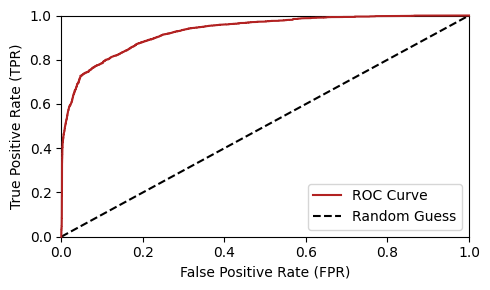

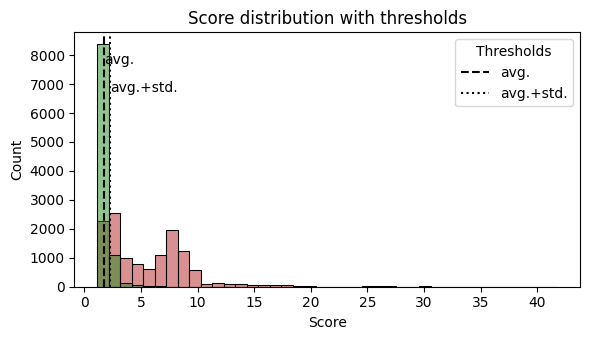

TPR-FPR @avg: 0.94-0.31
TPR-FPR @avg+std: 0.79-0.10


In [44]:
# Calculate perplexity scores on test
y_score = gpt2_detector.score(X_test_text)
y_score_val = gpt2_detector.score(X_val_text)

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test_binary, y_score)
print(f'ROC AUC Score: {roc_auc:.4f}')
roc_pauc = roc_auc_score(y_test_binary, y_score, max_fpr=0.01)
print(f'ROC Partial AUC Score: {roc_pauc:.4f}')

# Use the existing plot_roc function
plot_roc(y_test_binary, y_score, savefig=os.path.join(results_path, f'ROC_GPT2'), show=True)

metrics = plot_score_hist_with_thresholds(
    y_true=y_test_binary,
    y_score=y_score,
    y_score_val=y_score_val,          # or None to use y_score
    figsize=(6, 3.5),
    bins=40,
    stat="count",
    title="Score distribution with thresholds",
)
print(f"TPR-FPR @avg: {metrics['tpr_thr_avg']:.2f}-{metrics['fpr_thr_avg']:.2f}")
print(f"TPR-FPR @avg+std: {metrics['tpr_thr_avg_std']:.2f}-{metrics['fpr_thr_avg_std']:.2f}")